# How to Train YOLO-Net for License Plate Detection


## Introduction

In this notebook, we will train YOLO-Net for License Plate (LP) detection using 
- [DarkNet framework](https://github.com/AlexeyAB/darknet.git) by Alexey - an open source neural network framework written in C and CUDA
- [darknet53.conv](https://pjreddie.com/media/files/darknet53.conv.74) - YOLO v3 architecture based model trained on Imagenet dataset as pretrained model
- [OpenALPR benchmark](https://platerecognizer.com/number-plate-datasets/) - as training dataset

The process of training YOLO-Net for LP detection involves, 
1. Environment Setup 
```
    1.1 Clone DarkNet framework
    1.2 Compile DarkNet framework
```
2. Data Preparation
```
    2.1 Download dataset
    2.2 Generate required text files for traning
    2.3 Download pretrained model
    2.4 Download config file
```
3. Train the Model

4. Inference
```
    4.1 Download test image
    4.2 Utility functions
    4.3 Load the trained model
    4.4 Infer on the test image
    4.5 Display inference
```

## 1. Environment Setup 

### 1.1 Clone DarkNet framework



We will use [DarkNet framework](https://github.com/AlexeyAB/darknet.git) by Alexey which has many modifications and improvements and is actively maintained by him.

In [0]:
!git clone https://github.com/AlexeyAB/darknet.git

### 1.2 Compile DarkNet framework


Before we compile, we have to make some changes to the `Makefile` to enable followings
1. Build darknet with OpenCV
1. Build with CUDA enabled
1. Build with cuDNN enabled

In [0]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile  # Build darknet with OpenCV
!sed -i 's/GPU=0/GPU=1/' Makefile        # Build with CUDA enabled
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile    # Build with cuDNN enabled
!make |& tee build_log.txt
print('Compilation of DarkNet finished...')

## 2. Data Preparation

### 2.1 Download dataset

[OpenALPR benchmark](https://github.com/openalpr/benchmarks/tree/master/endtoend/) is a collection of labeled images of vehicles in Europe, Brazil and the US. Each has bounding box around the plate and the value of the license plate.

To train on custom dataset, we need to create `.txt`-file for each `.jpg`-image-file - in the same directory and with the same name, but with `.txt`-extension, and put to file: object number and object coordinates on this image, for each object in new line: 

`<object-class> <x_center> <y_center> <width> <height>`

  Where: 
  * `<object-class>` - integer object number from `0` to `(classes-1)`
  * `<x_center> <y_center> <width> <height>` - float values **relative** to width and height of image, it can be equal from `(0.0 to 1.0]`
  * for example: `<x> = <absolute_x> / <image_width>` or `<height> = <absolute_height> / <image_height>`
  * Note: `<x_center> <y_center>` - are center of rectangle (are not top-left corner)

We have shared prepared dataset which can be download from [here](https://www.dropbox.com/s/x38sqxxmem335gv/images.zip?dl=0).

In [0]:
!wget "https://www.dropbox.com/s/x38sqxxmem335gv/images.zip?dl=0" -O dataset.zip
!unzip -q dataset.zip

### 2.2 Generate required text files for traning

We will create two text file 1) `data_train.txt` and 2) `data_test.txt` which contains absolute path to train images and test images respectively. The dataset is split into train and test in the ratio of 90:10. So, we will use 90% of the total images for training and the rest for testing after a few iterations of training.

In [0]:
import random
import os
import subprocess
import sys

image_dir = "./images"
f_val = open("data_test.txt", 'w')
f_train = open("data_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
  if(f.split(".")[-1] == "jpg"):
    ind += 1
      
    if ind in test_array:
      f_val.write(image_dir+'/'+f+'\n')
    else:
      f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

### 2.3 Download pretrained model


When you train an object detector on custom dataset, it is a good idea to leverage existing models trained on very large datasets even though the large dataset may not contain the object you are trying to detect. This process is called *transfer learning*.

We will use YOLO v3 architecture based model trained on Imagenet dataset as pretrained model.

In [0]:
!wget "https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1" -O darknet53.conv.74

### 2.4 Download Config file




We have provided config files to specify the various training parameters. A gist of all the parameters is as follows,

1. `class.names`: contains the names of all the classes to be trained. In our case it contains `License plate` as class name.
1. `yolov3-LP-train.cfg`: contains model training related parameters
1. `yolov3-LP-test.cfg`: contains parameters related to model testing
1. `yolov3-LP-setup.data`: The content of the file is as follow 
> 
```shell
classes = 1 # number of object classes. It's 1 in our case.
train   = data_train.txt # path to text file containing absolute path to train images
valid   = data_test.txt # path to text file containing absolute path to test images
names   = class.names # path to file contain the names of all classses
backup  = backup/ # path to an existing directory where intermediate weights files will be stored as the training progresses
```

In [0]:
!wget "https://www.dropbox.com/sh/5y72h8ul8654y9i/AAAFwOwOl7bsQ4BmuxraKBRta?dl=0" -O yolov3_LP.zip
!unzip -q yolov3_LP.zip

## 3. Train the Model


Execute following command to start model training, by specifying
1. path to the setup file,
1. path to config file,
1. path to pretrained convolutional weights file

We are  passing some flags such as,
- `dont_show` to prevent displaying the graphs. 
Since `Colab` does not support, this flag will avoid code crashing. However you can display the graphs if you run this notebook on your local system.
- `map` - to calculate mAP - mean average precision for the test data specified by `data_test.txt` file.

In [0]:
!./darknet detector train yolov3-LP-setup.data yolov3-LP-train.cfg darknet53.conv.74  -dont_show -map 2> train_log.txt

### Caveat

Ideally, as the training process progress, training loss should decrease. However, we observed that occasionally (not always) training loss shoots up to suddenly around ~100 iterations. This may lead to a code crash also.

In such cases, we recommend to restart the training process again and keep watch on training loss. It should decrease as training progress.

### Download Link


After 500 iterations of training, model achieved mAP @ 0.5 around 94%. The same model can be downloaded from [here](https://www.dropbox.com/s/vw9omi6tjntp6vr/yolov3-LP-train_best.weights?dl=0) which we will use in LP detection using YOLO-Net for ALPR system in next notebook.

## 4. Inference



### 4.1 Download test image

In [0]:
!wget "https://raw.githubusercontent.com/openalpr/benchmarks/master/endtoend/br/JOG9221.jpg" -O test_img.jpg

### 4.2 Utility functions

Here, we define few utility functions like,
- `getOutputsNames`: Get the names of the output layers for given input neural network.
- `postprocess`: uses `cv.dnn.NMSBoxes` internally to perform non maximum suppression to eliminate redundant overlapping boxes with lower confidences
- `drawPred:` to draw the predicted bounding box


In [0]:
#@title
# Import necessary modules
import cv2 as cv

# Get the names of the output layers
def getOutputsNames(net):
  """ Get the names of the output layers.
  
  Generally in a sequential CNN network there will be 
  only one output layer at the end. In the YOLOv3 
  architecture, there are multiple output layers giving
  out predictions. This function gives the names of the 
  output layers. An output layer is not connected to 
  any next layer.
  
  Args
    net : YOLOv3 architecture based neural network.
  """
  # Get the names of all the layers in the network
  layersNames = net.getLayerNames()
  # Get the names of the output layers, i.e. the layers with unconnected outputs
  return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs, confThreshold, nmsThreshold=0.4):
  frameHeight = frame.shape[0]
  frameWidth = frame.shape[1]

  classIds = []
  confidences = []
  boxes = []
  # Scan through all the bounding boxes output from the network and keep only the
  # ones with high confidence scores. Assign the box's class label as the class with the highest score.
  classIds = []
  confidences = []
  boxes = []
  predictions = []

  for out in outs:
      # print("out.shape : ", out.shape)
      for detection in out:
          scores = detection[5:]
          classId = np.argmax(scores)
          confidence = scores[classId]
          if confidence > confThreshold:
              center_x = int(detection[0] * frameWidth)
              center_y = int(detection[1] * frameHeight)
              width = int(detection[2] * frameWidth)
              height = int(detection[3] * frameHeight)
              left = int(center_x - width / 2)
              top = int(center_y - height / 2)
              classIds.append(classId)
              confidences.append(float(confidence))
              boxes.append([left, top, width, height])

  # Perform non maximum suppression to eliminate redundant overlapping boxes with
  # lower confidences.
  if nmsThreshold:
    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
  else:
    indices = [[x] for x in range(len(boxes))]

  for i in indices:
    i = i[0]
    box = boxes[i]
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]
    predictions.append([classIds[i], confidences[i], [left, top, left + width, top + height]])

  return predictions

# Draw the predicted bounding box
def drawPred(frame, pred):
  classId = pred[0]
  conf = pred[1]
  box = pred[2]
  left, top, right, bottom =  box[0], box[1], box[2], box[3]
  # draw bounding box
  cv.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

### 4.3 Load the trained model


In [0]:
# Import necessary modules
import cv2 as cv
import numpy as np
import os

# Initialize the parameters
confThreshold = 0.2  # Confidence threshold
nmsThreshold  = 0.4  # Non-maximum suppression threshold
inpWidth      = 416  # Width of network's input image
inpHeight     = 416  # Height of network's input image
yolo_lp_confi_path    = "yolov3-LP-test.cfg"
yolo_lp_weights_path  = "backup/yolov3-LP-train_best.weights"

# Download the pre-trained model if your training was not complete
if not os.path.exists(yolo_lp_weights_path):
    print("Downloading Pretrained model...")
    !wget https://www.dropbox.com/s/vw9omi6tjntp6vr/yolov3-LP-train_best.weights?dl=0 -O "backup/yolov3-LP-train_best.weights" --quiet


# load the network
lp_net = cv.dnn.readNetFromDarknet(yolo_lp_confi_path, yolo_lp_weights_path)
lp_net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
lp_net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

### 4.4 Infer on the test image


In [0]:
# read test image
test_img = cv.imread('test_img.jpg')
# Create a 4D blob from a frame.
blob = cv.dnn.blobFromImage(test_img, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
# Sets the input to the network
lp_net.setInput(blob)
# Runs the forward pass to get output of the output layers
outs = lp_net.forward(getOutputsNames(lp_net))
# Remove the bounding boxes with low confidence
predictions = postprocess(test_img, outs, confThreshold, nmsThreshold)

### 4.5 Display inference

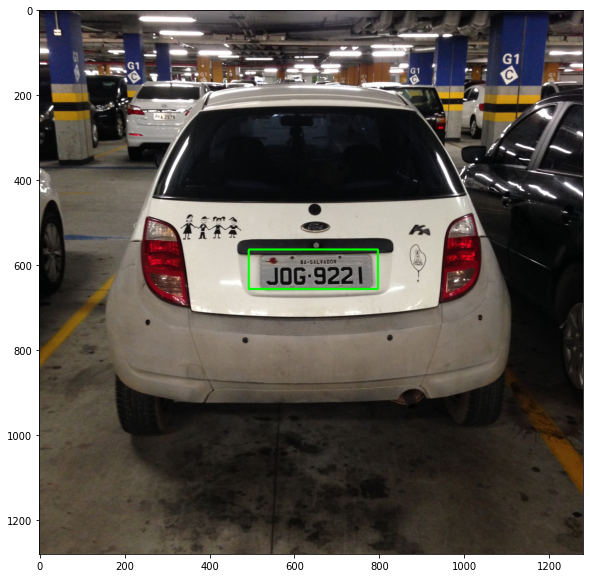

In [0]:
# Import necessary modules
import matplotlib
import matplotlib.pyplot as plt
for pred in predictions:
  drawPred(test_img, pred)
# Display inference
fig=plt.figure(figsize=(10, 10))
plt.imshow(test_img[:,:,::-1])

Here, we have trained License plate detector using YOLO, it is observed that the performance improves if the detection is applied after the vehicle detection step. We will see more about this in the implementations of ALPR system.
